In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import nltk
from nltk.corpus import stopwords
!pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Nmf
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from operator import itemgetter

nltk.download('stopwords')


from nltk.stem.wordnet import WordNetLemmatizer
import spacy

from pprint import pprint
!pip install little-mallet-wrapper
import little_mallet_wrapper as lmw

#pd.set_option("display.max_rows", None, "display.max_columns", None) #to show everything 
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm') 
nlp.disable_pipes('ner', 'parser')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f4270fb5bb0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f4270fb5590>)]


# Part A: Clean and organize all the text files  
1. Create seperate variables and dataframes for each of the books in case you want to conduct book level analysis   
2. Create a combined dataframe of all the text for overall analysis - include some meta data on book


In [2]:
file_names = ['1 the duke and i.txt', '2 the viscount who loved me.txt', '3 an offer from a gentleman.txt', 
             '4 romancing mister brigerton.txt', '5 to sir phillip, with love.txt', '6 when he was wicked.txt', 
             '7 its in his kiss.txt', '8 on the way to the wedding.txt']

bk_dfs = []

In [3]:
def bk_to_df(filename): 
    '''
    takes in text file
    returns text in dataframe with each row containing chapter text
    '''
    
    with open(filename, encoding='utf8') as file: 
        bk = file.read()
    
    bk = bk.replace('\n',' ')
    bk = bk.replace('\t',' ')
    split_bk =bk.split('\x0cChapter_')
    split_bk = [text.replace('\x0c', '') for text in split_bk]
    
    chaptnum = len(split_bk)-1
    #print(chaptnum)
    
    title = split_bk[0].strip()
    #print(title)
        
    bk_df = pd.DataFrame(np.arange(chaptnum), columns = ['chapter'])
    bk_df['text'] = split_bk[1:]
    bk_df['title'] = title.lower()
    bk_df['book_num']= int(filename[0])
    
    bk_df = bk_df[['book_num', 'title', 'chapter', 'text']]
    #display(bk_df)
    return bk_df
    

In [4]:
for i in file_names: 
    bk_dfs.append(bk_to_df(i))

In [5]:
#dataframes of individual books (not really needed)
bk1 = bk_dfs[0]
bk2 = bk_dfs[1]
bk3 = bk_dfs[2]
bk4 = bk_dfs[3]
bk5 = bk_dfs[4]
bk6 = bk_dfs[5]
bk7 = bk_dfs[6]
bk8 = bk_dfs[7]

In [6]:
all_bks_df = pd.concat(bk_dfs)
#all_bks_df.to_csv('all text.csv')
all_bks_df

book_num  ...                                               text
0          1  ...   0 Prologue_ The birth of Simon Arthur Henry F...
1          1  ...   1 The Bridgertons are by far the most prolifi...
2          1  ...   2 The new Duke of Hastings is a most interest...
3          1  ...   3 It has been whispered to This Author that N...
4          1  ...   4  London is awash these days with Ambitious ...
..       ...  ...                                                ...
22         8  ...   22        In which all hell breaks loose.    ...
23         8  ...   23        In which Our Hero risks everything....
24         8  ...   24        In which Our Hero leaves Our Heroin...
25         8  ...   25        In which we learn what happened, a ...
26         8  ...   26 Epilogue        In which Our Hero and Hero...

[193 rows x 4 columns]

# Part B: Exploratory Data Analysis of Text  (before text cleaning)
Exploring trends in word length by chapter and by book

In [7]:
#get number of words in each chapter 
all_bks_df['num_words'] = all_bks_df['text'].map(lambda x: x.split()).str.len()
all_bks_df

book_num  ... num_words
0          1  ...      3238
1          1  ...      3895
2          1  ...      4994
3          1  ...      5524
4          1  ...      4250
..       ...  ...       ...
22         8  ...      2292
23         8  ...      2495
24         8  ...      4637
25         8  ...      4628
26         8  ...       903

[193 rows x 5 columns]

In [8]:
#average word count in chapter 
display(all_bks_df['num_words'].describe())

count     193.000000
mean     4029.512953
std      1096.762908
min       239.000000
25%      3555.000000
50%      4143.000000
75%      4719.000000
max      6371.000000
Name: num_words, dtype: float64

In [9]:
#mode of chapter word count
all_bks_df['num_words'].mode()

0    4103
dtype: int64

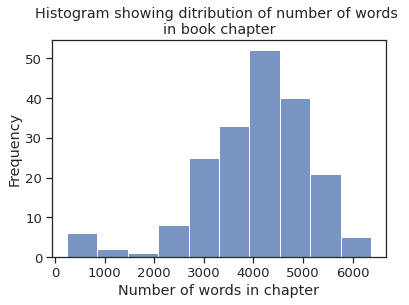

In [10]:
#word count distribution among book chapters
sns.histplot(data= all_bks_df['num_words'], bins= 10, palette="Blues_d")
plt.title('Histogram showing ditribution of number of words \nin book chapter')
plt.xlabel('Number of words in chapter')
plt.ylabel('Frequency')

plt.show()

book_num                        title  chapter  num_words
0         1               the duke and i       23      96969
1         2    the viscount who loved me       24     104970
2         3    an offer from a gentleman       25      99478
3         4  romancing mister bridgerton       25     103155
4         5    to sir phillip, with love       21      91089
5         6           when he was wicked       25      90309
6         7             it's in his kiss       23      89877
7         8    on the way to the wedding       27     101849

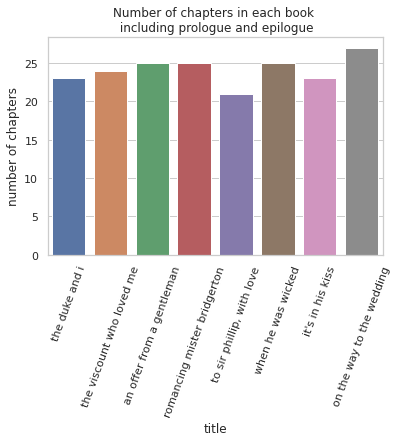

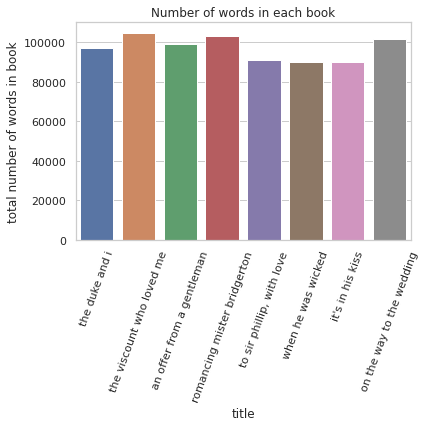

In [11]:
#book chapter analysis
bk_words = pd.DataFrame(all_bks_df.groupby(by=['book_num', 'title']).sum()['num_words'])


bk_chapts = pd.DataFrame(all_bks_df.groupby(by=['book_num', 'title']).count()['chapter'])

bk_details = pd.concat([bk_chapts, bk_words], axis= 1)
bk_details = bk_details.reset_index()

display(bk_details)


sns.set_theme(style="whitegrid")
sns.barplot(data=bk_details, x='title', y='chapter')
plt.ylabel('number of chapters')
plt.title('Number of chapters in each book \n including prologue and epilogue')
plt.xticks(rotation=70)

plt.show()

sns.barplot(data=bk_details, x='title', y='num_words')
plt.ylabel('total number of words in book')
plt.title('Number of words in each book')
plt.xticks(rotation=70)

plt.show()


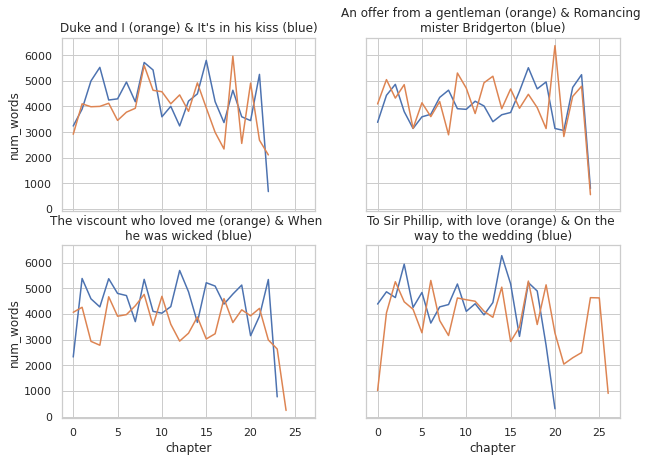

In [12]:
#Analysis into number of words in chapters
#books roughly grouped by similar number of chapters with the exception of the last graph on the bottom right

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7))


axes[0,0].set_title('Duke and I (orange) & It\'s in his kiss (blue)')
axes[0,1].set_title('An offer from a gentleman (orange) & Romancing \nmister Bridgerton (blue)')
axes[1,0].set_title('The viscount who loved me (orange) & When \nhe was wicked (blue)')
axes[1,1].set_title('To Sir Phillip, with love (orange) & On the \nway to the wedding (blue)')

for i in [1,7]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax1 = sns.lineplot(ax=axes[0, 0], data=bk_words, x='chapter', y='num_words')

for i in [3, 4]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax2 = sns.lineplot(ax=axes[0, 1], data=bk_words, x='chapter', y='num_words')

for i in [2,6]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax3 = sns.lineplot(ax=axes[1, 0], data=bk_words, x='chapter', y='num_words')

for i in [5,8]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax4 = sns.lineplot(ax=axes[1, 1], data=bk_words, x='chapter', y='num_words')



# Part C: Text preprocessing & EDA of preprocessed text
Remove stopwords, lemmatize words, create words clouds 

In [13]:
all_bks_df.head(2)

book_num  ... num_words
0         1  ...      3238
1         1  ...      3895

[2 rows x 5 columns]

In [14]:
#remove punctuation and change text to lower case 
all_bks_df['text'] = \
all_bks_df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
all_bks_df['text'] = \
all_bks_df['text'].map(lambda x: x.lower())
all_bks_df['text'].head()

data = all_bks_df.text.values.tolist() 

In [15]:
#functions to use to clean text
stop_words = stopwords.words('english')

def sent_to_words(sentences): 
    '''
    creates list of words and removes punctuation
    '''
    for sentence in sentences: 
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
data_words = list(sent_to_words(data))
data_words_nostops = remove_stopwords(data_words)
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

With stop words, punctuation removed and noun/adjectives/verbs/adverbs lemmatized, I now create a word cloud to observe the frequently occurring words in the entire dataset

In [18]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def gen_wordcloud(data, remove_names):
    
    if remove_names: 
        stopwords = ['anthony', 'benedict', 'colin', 'daphne', 'eloise', 'francesca', 'gregory', 'hyacinth', 
                     'brigerton', 'penelope', 'whistledown', 'kate', 'violet', 'marina', 'simon', 'phillip', 'sophie'] #names from google results for brigerton characters
        
    else: 
        stopwords = ''
        
    cloudwords = [j for i in data for j in i]
    cloudwords = ' '.join(cloudwords)
    
    w = WordCloud(background_color= "white", stopwords=stopwords, height=1000, width= 1700,max_words=200, min_font_size = 8)
    w.generate(cloudwords)

    plt.figure(figsize = (10, 5)) 
    plt.imshow(w, interpolation="bilinear")
    plt.axis("off")
    plt.show()

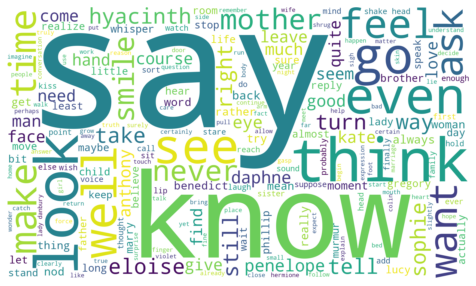

In [ ]:
gen_wordcloud(data_lemmatized, False)

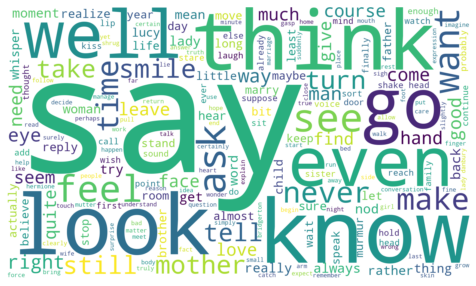

In [ ]:
gen_wordcloud(data_lemmatized, True) #names removed

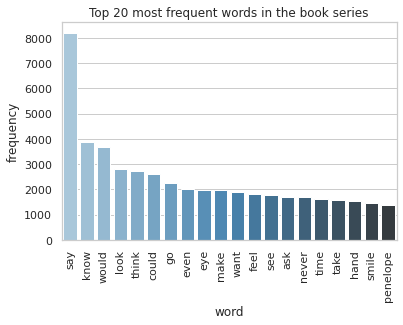

In [19]:
all_words_bkseries = [j for i in data_lemmatized for j in i] #in list format

top_20 = pd.DataFrame(Counter(all_words_bkseries).most_common(20), columns=['word', 'frequency'])


sns.set_theme(style="whitegrid")
sns.barplot(x='word', y='frequency', data=top_20, palette="Blues_d")
plt.title('Top 20 most frequent words in the book series')
plt.xticks(rotation=90)

plt.show()

In [21]:
#number of unique words in book series after preprocessing 
len(set(all_words_bkseries))

11634

In [20]:
#some variables that will be useful

all_words = ' '.join(all_words_bkseries) #all words in the book series in string format 

key_names = ['anthony', 'benedict', 'colin', 'daphne', 'eloise', 'francesca', 'gregory', 'hyacinth', 'bridgerton', 'penelope', 'gareth', 'hermione',
             'whistledown', 'kate', 'violet', 'marina', 'simon', 'phillip', 'sophie', 'danbury', 'lucinda', 'felicity', 'penwood', 'posy']

In [22]:
len(all_words)

1926311

# Part D: Find optimal number of topics by plotting divergence between Jaccard similarity and Coherence for LDA model    

Ran Jaccard Coherence divergence 6 times: 14, 11, 13, 8, 10, 11

In [57]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

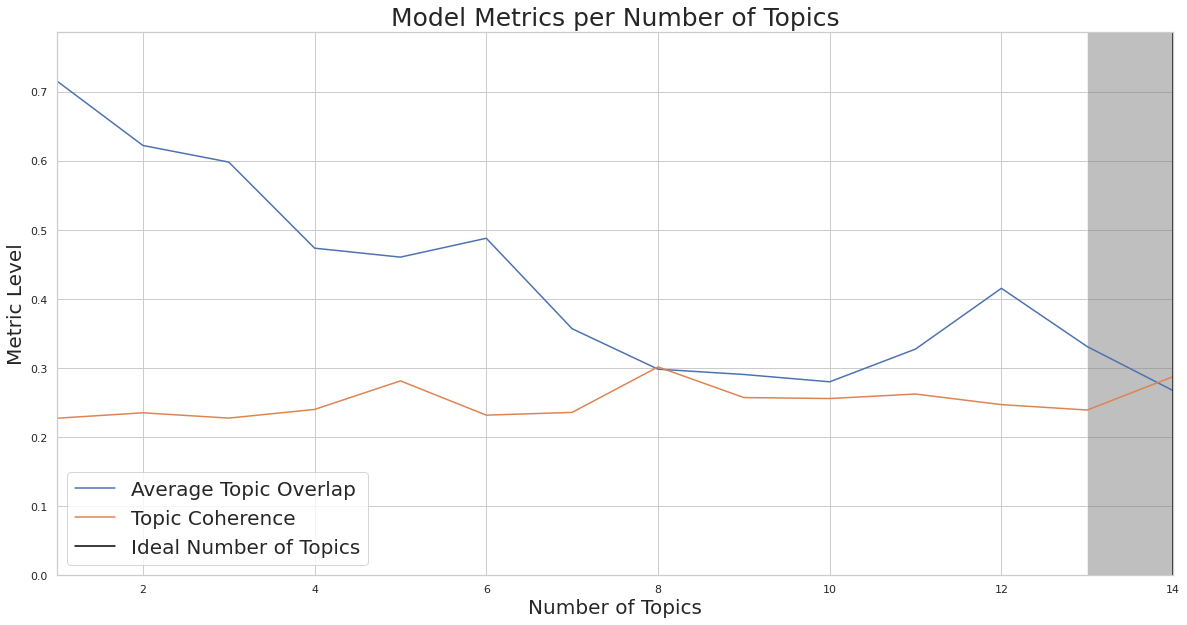

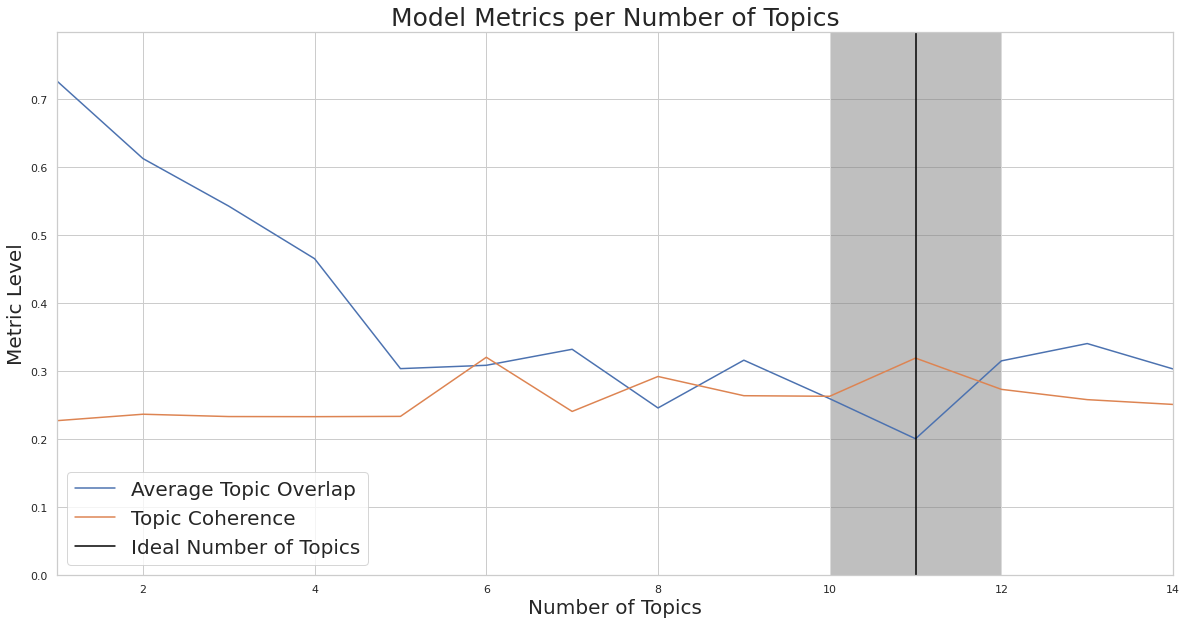

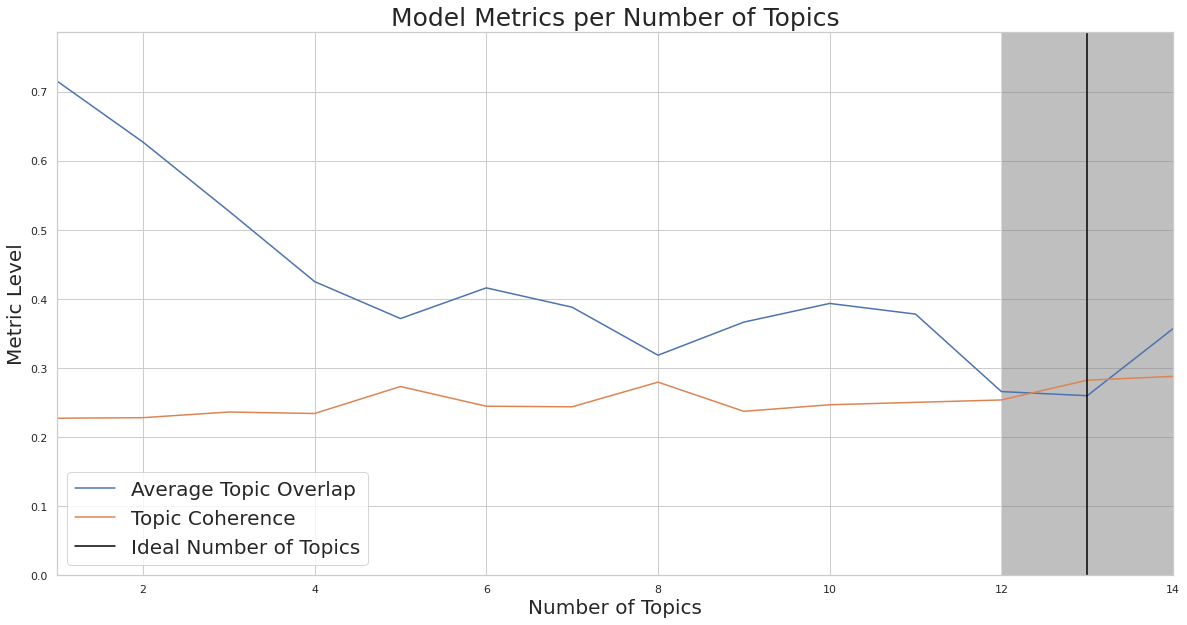

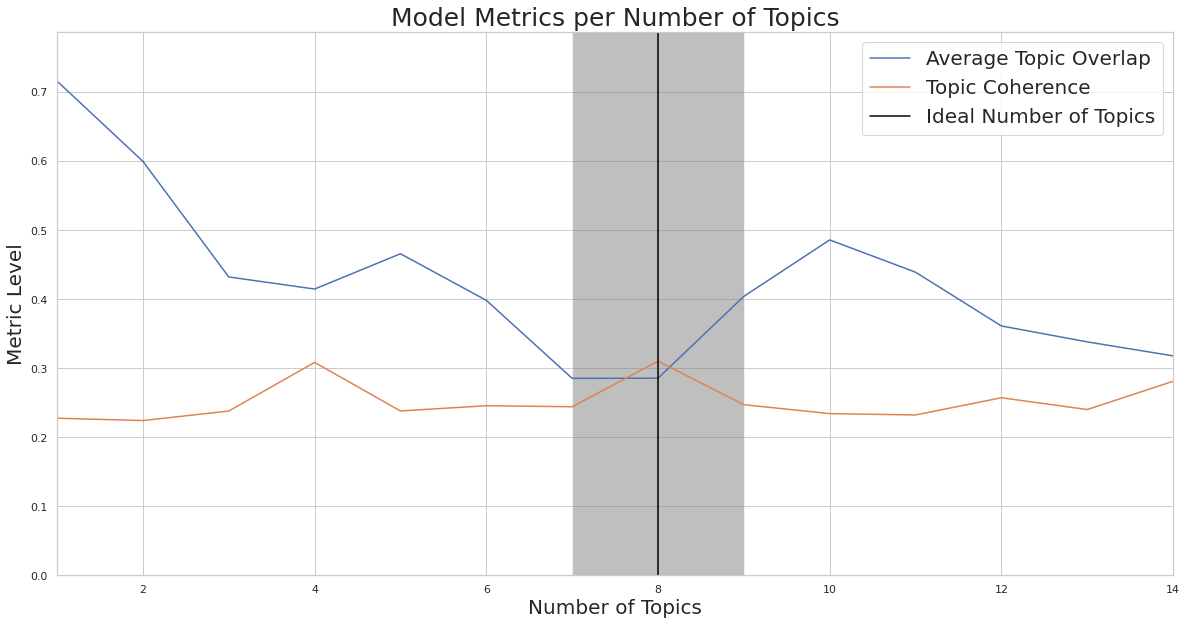

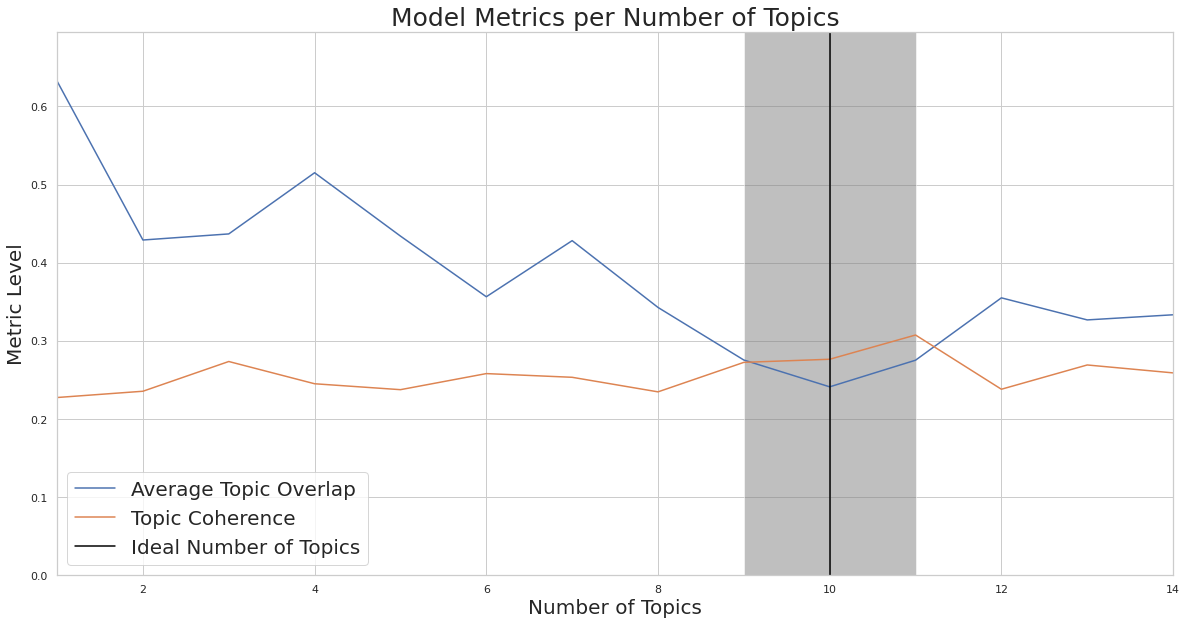

In [61]:
id2word = corpora.Dictionary(data_lemmatized)
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

for i in range(5): 

  # Considering 1-15 topics, as the last is cut off
  num_topics = list(range(16)[1:])
  num_keywords = 15

  LDA_models = {}
  LDA_topics = {}
  for i in num_topics:
      LDA_models[i] = LdaModel(corpus=bow_corpus,
                              id2word=id2word,
                              num_topics=i,
                              update_every=1,
                              chunksize=len(bow_corpus),
                              passes=20,
                              alpha='auto')

      shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                              num_words=num_keywords,
                                              formatted=False)
      LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
  LDA_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      LDA_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

  coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]
  coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
  coh_sta_max = max(coh_sta_diffs)
  coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
  ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
  ideal_topic_num = num_topics[ideal_topic_num_index]

  plt.figure(figsize=(20,10))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
  ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([0, y_max])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()   

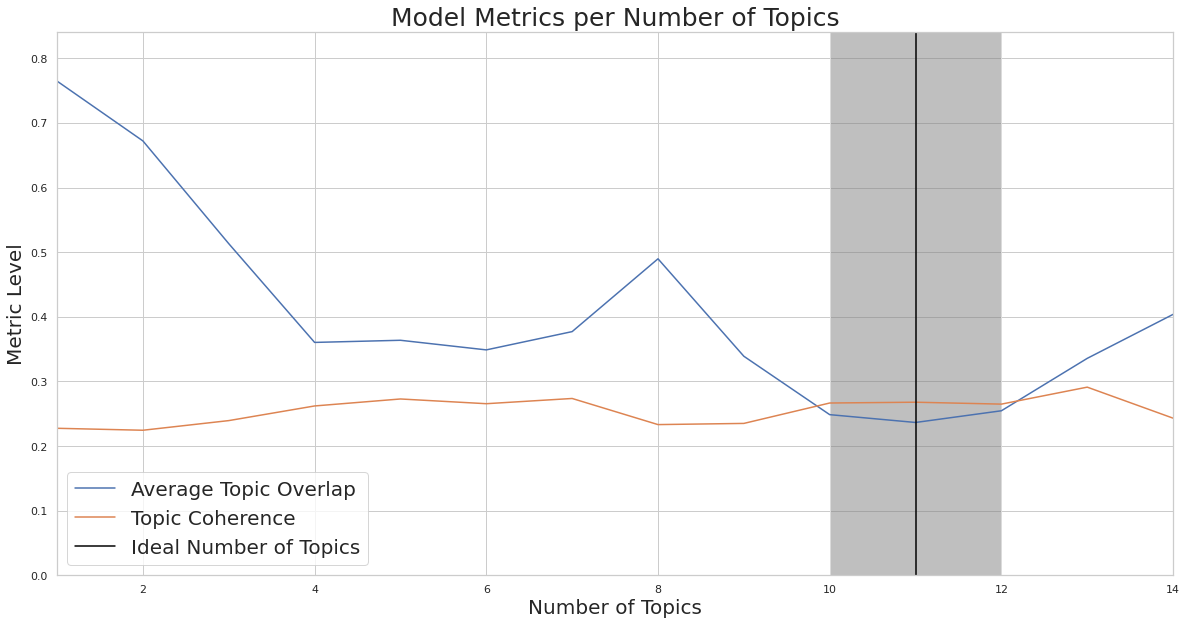

# Part E: Find optimal number of topics by plotting divergence between Jaccard similarity and Coherence for NMF Model 

Coherence Scores: [(1, 0.21161), (2, 0.22463), (3, 0.2797), (4, 0.33657), (5, 0.30752), (6, 0.32092), (7, 0.31919), (8, 0.35736), (9, 0.32942), (10, 0.34256), (11, 0.34044), (12, 0.36185), (13, 0.3787), (14, 0.37334), (15, 0.35601), (16, 0.37022), (17, 0.35466), (18, 0.35269), (19, 0.36434), (20, 0.34622), (21, 0.35632), (22, 0.35435), (23, 0.35273), (24, 0.33765), (25, 0.35085), (26, 0.33771), (27, 0.35071), (28, 0.34219), (29, 0.34913)]
13


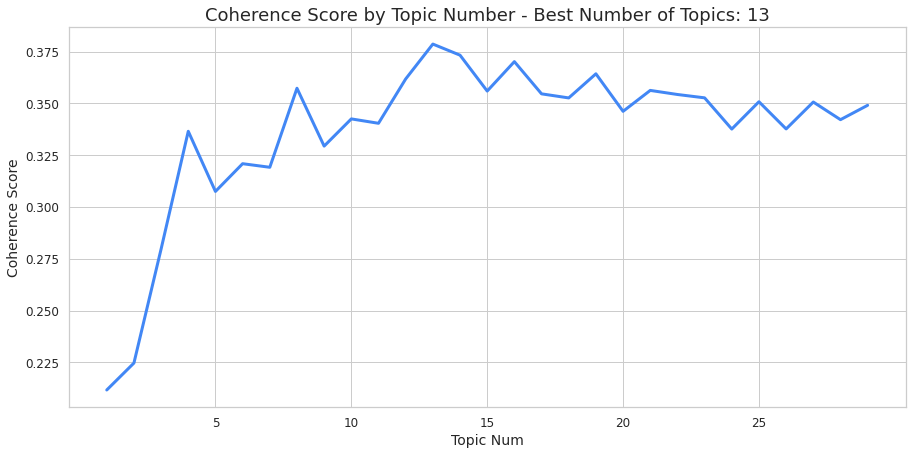

In [34]:
#adapted code from https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/topic_modeling_cnn.ipynb
num_topics = list(range(30)[1:])
coherence_scores = []

id2word = corpora.Dictionary(data_lemmatized)

# Filter out extremes to limit the number of features
id2word.filter_extremes(no_below=0.1, no_above=0.8, keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

for i in num_topics:
  nmf_models = Nmf(
      corpus=bow_corpus,
      num_topics=i,
      id2word=id2word,
      chunksize=2000,
      passes=5,
      kappa=.1,
      minimum_probability=0.01,
      w_max_iter=300,
      w_stop_condition=0.0001,
      h_max_iter=100,
      h_stop_condition=0.001,
      eval_every=10,
      normalize=True
  )
  coherences = CoherenceModel(model=nmf_models, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_scores.append(round(coherences.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(num_topics, coherence_scores))
print('Coherence Scores:', scores)
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(best_num_topics)

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    num_topics,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(num_topics) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)


plt.show()



# Part F: Run Preliminary topic models  
Using the optimal topic numbers for LDA and NMF, I note the opitmal topic number could be somewhere between 10-13, I run preliminary topic models using LDA, NMF, and LDA Mallet to determine whether further preprocessing of the text is needed. (Please note, I did not find optimal topic numbers for LDA Mallet because Jaccard-Coherence divergence takes so long to run)

## Part F1: Run LDA topic models for topic num 10, 13

In [ ]:
def run_lda(corpus, id2word, num_topics): 
  lda_model = gensim.models.ldamodel.LdaModel(
      corpus=corpus,    # Stream of document vectors or sparse matrix of shape (num_terms, num_documents)
      id2word=id2word,  # It is used to determine the vocabulary size, as well as for debugging and topic printing.
      num_topics=num_topics,    # The number of requested latent topics to be extracted from the training corpus.
      random_state=100, # Useful for reproducibility.
      update_every=1,   # Set to 0 for batch learning, > 1 for online iterative learning.How often model parameters should be updated 
      chunksize=100,    # Number of documents to be used in each training chunk.
      passes=10,        # Number of passes through the corpus during training.
      alpha='auto',     # auto: Learns an asymmetric prior from the corpus Hyperparameter that affect sparsity of topics 
      per_word_topics=True 
      # If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word,
      # along with their phi values multiplied by the feature-length (i.e. word count)
  )

  #pprint(lda_model.print_topics()) #unhash this version if you want to see probabilities for each of the words 
  for j, (topic_num, prop_topic) in enumerate(lda_model.print_topics()):
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    print('Topic', topic_num, ':', topic_keywords)
    


In [ ]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized #creates corpus
corpus = [id2word.doc2bow(text) for text in texts] #term doc frequency 

for i in [10, 13]: 
  print('LDA topic model for', i, 'topics (key character NOT names removed):')
  run_lda(corpus, id2word, i)
  print('\n')

LDA topic model for 10 topics (key character NOT names removed):
Topic 0 : say, penelope, lady, think, look, know, mother, would, hyacinth, smile
Topic 1 : ink, briarly, eloise, penelope, bis, penchant, tenaciously, hairbrush, disloyal, evasive
Topic 2 : say, know, would, could, go, think, look, even, want, feel
Topic 3 : say, think, could, would, know, look, penelope, go, make, even
Topic 4 : magistrate, cell, dog, posy, penwood, rat, warden, curricle, theft, clip
Topic 5 : furnace, cloth, drift, miniature, pitcher, sketchbook, fussy, clammy, landscape, sophie
Topic 6 : ungainly, pvermuch, editor, smiling, talented, added, scribbling, disagreement, ending, publisher
Topic 7 : say, would, know, look, think, could, make, go, ask, feel
Topic 8 : say, know, would, look, feel, think, could, eye, even, penelope
Topic 9 : daphne, hand, want, eye, say, body, know, whisper, move, lip


LDA topic model for 13 topics (key character NOT names removed):
Topic 0 : penelope, say, lady, danbury, thin

In [ ]:
#remove key names from data_lemmatized

new_data_lemma = []
for chapt in data_lemmatized:
  for word in chapt: 
    if word in key_names: 
      chapt.remove(word)
  new_data_lemma.append(chapt)

#run lda with key names removed 
id2word = corpora.Dictionary(new_data_lemma)
texts = new_data_lemma #creates corpus
corpus = [id2word.doc2bow(text) for text in texts] #term doc frequency 

for i in [10, 13]: 
  print('LDA topic model for', i, 'topics (key character names removed):')
  run_lda(corpus, id2word, i)
  print('\n')



LDA topic model for 10 topics (key character names removed):
Topic 0 : say, would, know, look, think, could, lady, ask, even, go
Topic 1 : say, lady, look, would, know, think, go, rosamund, see, ask
Topic 2 : say, know, would, could, want, go, feel, think, look, eye
Topic 3 : say, know, would, make, look, eye, could, never, think, hand
Topic 4 : hand, whisper, could, body, lip, say, slide, finger, know, breast
Topic 5 : say, know, think, would, look, eye, could, even, go, hand
Topic 6 : paper, society, author, letter, write, chamber, portia, birthday, family, pot
Topic 7 : say, know, would, look, see, could, think, eye, go, time
Topic 8 : middlethorpe, terrace, hampstead, heath, southern, shorten, devastating, revolve, undivided, unknowing
Topic 9 : say, look, know, could, make, think, go, would, eye, see


LDA topic model for 13 topics (key character names removed):
Topic 0 : say, would, know, look, think, lady, could, ask, smile, even
Topic 1 : lady, say, look, would, rosamund, think

## Part F2: Run LDA Mallet topic models for topic num 10, 13

In [ ]:
import os
path_to_mallet = 'C:/mallet/bin/mallet'
output_directory_path = 'lmwoutput'
print(os.path.exists(output_directory_path))

True


In [ ]:
training_data = [lmw.process_string(t) for t in all_bks_df['text'].tolist()]
training_data = [d for d in training_data if d.strip()]

print(len(training_data))

lmw.print_dataset_stats(training_data)

193
Number of Documents: 193
Mean Number of Words per Document: 1940.5
Vocabulary Size: 16424


In [ ]:
for i in [10,13]: 
    topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet,
                                                                  output_directory_path,i,training_data)
    assert(len(topic_distributions) == len(training_data))
    print('LDA Mallet topic model for ', i, 'topics (key character names NOT removed):')
    for i, t in enumerate(topic_keys):
        print(i, '\t', ' '.join(t[:10]))
    print('\n')      
                                                     

Importing data...
Complete
Training topic model...
Complete
LDA Mallet topic model for  10 topics (key character names NOT removed):
0 	 kate anthony edwina mary sheffield sister lady miss viscount bridgerton
1 	 eloise phillip children amanda oliver sir father nurse arina day
2 	 francesca michael john kilmartin janet earl couldn stirling god helen
3 	 hyacinth gareth lady clair father danbury baron grandmother miss isabella
4 	 penelope colin daphne simon lady anthony whistledown danbury eloise duke
5 	 said back looked asked right didn eyes one know head
6 	 would said well one could even never bridgerton mother quite
7 	 sophie benedict lady araminta posy bridgerton mrs penwood rosamund earl
8 	 lucy gregory hermione lady lucinda watson haselby uncle could richard
9 	 could would lips wanted knew felt whispered never time eyes


Importing data...
Complete
Training topic model...
Complete
LDA Mallet topic model for  13 topics (key character names NOT removed):
0 	 eloise phillip chi

In [ ]:
#remove keynames from text dataset
training_data = [lmw.process_string(text=t, stop_words_extra=key_names) for t in all_bks_df['text'].tolist()]
training_data = [d for d in training_data if d.strip()]

print(len(training_data))

lmw.print_dataset_stats(training_data)

193
Number of Documents: 193
Mean Number of Words per Document: 1836.5
Vocabulary Size: 16400


In [ ]:
for i in [10,13]: 
    topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet,
                                                                  output_directory_path,i,training_data)
    assert(len(topic_distributions) == len(training_data))
    print('LDA Mallet topic model for ', i, 'topics (key character names removed):')
    for i, t in enumerate(topic_keys):
        print(i, '\t', ' '.join(t[:10]))
    print('\n')      
                     

Importing data...
Complete
Training topic model...
Complete
LDA Mallet topic model for  10 topics (key character names removed):
0 	 lucy uncle watson haselby richard lord miss love could fennsworth
1 	 lips hands whispered could body fingers kiss felt wanted skin
2 	 lady mother sister well miss smile rather featherington course murmured
3 	 mother london children father two years tea since read get
4 	 araminta cressida lady earl rosamund countess maid mrs mother masquerade
5 	 edwina mary clair father sheffield lord baron grandmother miss viscount
6 	 duke mrs hastings crabtree nigel grace duchess nurse colson clyvedon
7 	 said would one could know even didn like looked think
8 	 michael john sir amanda oliver kilmartin children arina course quite
9 	 back eyes didn get door whispered voice bed head still


Importing data...
Complete
Training topic model...
Complete
LDA Mallet topic model for  13 topics (key character names removed):
0 	 araminta lady mrs rosamund crabtree earl maid

From the above results we see that all names should be removed or topics will be difficult to interpret

## Part F3: Run NMF topic models for topic num 10, 13
code adapted from: https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/topic_modeling_cnn.ipynb

In [ ]:
def run_nmf(texts, use_stop, best_num_topics): 
  '''
  function producing nmf topic model topics
  '''

  if use_stop: 
    # Convert a collection of raw documents to a matrix of TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(
        min_df=15, #ignore terms that have a document frequency strictly lower than the given threshold
        max_df=0.85, #ignore terms that have a document frequency strictly higher than the given threshold
        max_features=5000,
        stop_words= key_names,
        preprocessor=' '.join
    )
  else: 
    tfidf_vectorizer = TfidfVectorizer(
        min_df=15, 
        max_df=0.85, 
        max_features=5000,
        preprocessor=' '.join)

  
  tfidf = tfidf_vectorizer.fit_transform(texts) #returns (document_id, token_id) and value following the tuple represents the tf-idf score of a given token in a given document

  # Save the feature names for later to create topic summaries
  tfidf_fn = tfidf_vectorizer.get_feature_names()

  # Run the nmf model
  nmf = NMF(
      n_components=best_num_topics,
      init='nndsvd',
      max_iter=500,
      l1_ratio=0.0,
      solver='cd',
      alpha=0.0,
      tol=1e-4).fit(tfidf)

  W = nmf.fit_transform(tfidf)
  H = nmf.components_
  words = np.array(tfidf_vectorizer.get_feature_names())

  for i, topic in enumerate(H):
      print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))
  

In [ ]:
for i in [10, 13]: 
  print('NMF topic model for ', i, 'topics (key character names removed):')
  run_nmf(texts=data_lemmatized, use_stop=True, best_num_topics=i)
  
  print('\n\nNMF topic model for ', i, 'topics (key character names NOT removed):')
  run_nmf(texts=data_lemmatized, use_stop=False, best_num_topics=i)

  print('\n\n')

NMF topic model for  10 topics (key character names removed):
Topic 1: actually,conversation,reply,friend,shall,evening,sort,sister,dance,brother
Topic 2: moan,desire,touch,skin,slide,breast,whisper,body,finger,kiss
Topic 3: old,money,attention,dance,ballroom,cane,countess,people,girl,lady
Topic 4: letter,wife,sit,expect,marriage,suppose,sir,nurse,twin,child
Topic 5: week,shoe,girl,shall,marry,family,child,daughter,tea,mother
Topic 6: cane,murmur,kiss,father,lady,jewel,page,read,book,grandmother
Topic 7: laugh,heir,mother,boy,child,nurse,young,duke,son,father
Topic 8: marry,window,stare,run,step,door,wedding,whisper,carriage,church
Topic 9: fever,thunder,sit,night,die,cottage,sleep,storm,bed,rain
Topic 10: society,sit,writing,column,book,author,desk,paper,read,write


NMF topic model for  10 topics (key character names NOT removed):
Topic 1: ballroom,conversation,reply,friend,shall,evening,sort,sister,dance,brother
Topic 2: moan,desire,touch,skin,slide,breast,whisper,body,finger,kiss
T

#Part G: From preliminary topic models I decide to use NMF topic modeling and it will be a good idea to replace protagonist names with normalized versions of the name (i.e. male_loveinterest, female_loveinterest, 

In [ ]:
#code to replace key names in text with their normalized version 
#things to do 
new_data_lemmatized --
run optimal topic number with nmf --
run nmf topic model with optimal topic number --